In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import randint,uniform
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import InputLayer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from  scikeras.wrappers import KerasClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
import keras_tuner as kt

In [108]:
def load_data():
    train_data = pd.read_csv('train.csv')
    return train_data
train_data = load_data()
target_data = train_data["Personality"].copy()
training_data = train_data.drop(columns=["Personality","id"]).copy()

training_data['Socializing_effect'] = training_data['Social_event_attendance'] + training_data['Going_outside'] 
training_data['probability_of_having_friends'] = training_data['Socializing_effect'] / (training_data['Socializing_effect'].max() + 1e-5)
training_data['prob_of_going_outside'] = training_data['Going_outside'] / (training_data['Going_outside'].max() + 1e-5)
training_data['online_presence'] = training_data['Post_frequency'] * training_data['Friends_circle_size']

num_attributes = training_data.select_dtypes(include=[np.number]).columns.tolist()
cat_attributes = training_data.select_dtypes(exclude=[np.number]).columns.tolist()


corr_matrix = training_data.select_dtypes(include=[np.number]).corr()
training_data.head()
train_data.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [109]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean',missing_values=np.nan)),
    ('scaler', StandardScaler()),])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

pre_processor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_attributes),
    ('cat', cat_pipeline, cat_attributes),
])

le = LabelEncoder()
X_processed = pre_processor.fit_transform(training_data)
y_processed = le.fit_transform(target_data)

X_train, X_val, y_train, y_val = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

In [110]:
def compute_class_weights(train_data):
    class_weight = compute_class_weight(class_weight='balanced',classes = np.unique(train_data["Personality"]),y=train_data["Personality"])
    class_weight_dict = dict(enumerate(class_weight))
    print("Class weights computed")
    return class_weight_dict

class_weights = compute_class_weights(train_data)

Class weights computed


In [111]:
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall") ]


def build_model(hp):
    n_layers = hp.Int("no of layers", 1, 3, default=2)
    n_neurons = hp.Int("no of neurons", 32, 512, step=32, default=128)
    learning_rate = hp.Float("learning rate", 1e-4, 1e-2, sampling='log', default=1e-3)
    optimizer = hp.Choice("optimizer", ['adam', 'sgd'], default='adam')
    
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        
    model = tf.keras.Sequential()
    model.add(InputLayer(shape=(X_processed.shape[1],)))
    for _ in range(n_layers):
        model.add(Dense(n_neurons, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=metrics)
    
    return model 


In [112]:

def create_model(input_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    return model

rf_clf = RandomForestClassifier(n_estimators=120, max_depth=2,
                                min_samples_split=8, min_samples_leaf=2,
                                max_features='sqrt', bootstrap=False,ccp_alpha=0.05924145688620425,
                                class_weight=class_weights, random_state=42)


nn_clf = KerasClassifier(model=create_model,model__input_shape=(X_processed.shape[1],),epochs=10,
                         batch_size=32,verbose=1,random_state=42)

#nn_clf.fit(X_processed, y_processed)

In [113]:
tf.random.set_seed(42)

nn_model = create_model(input_shape=(X_processed.shape[1],))
nn_model.fit(X_processed, y_processed, epochs=10, batch_size=32, verbose=1, 
             validation_data=(X_val, y_val),class_weight=class_weights)

Epoch 1/10


/opt/anaconda3/envs/aiml_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-08 14:11:35.853281: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

579/579 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2680 - loss: 0.2196 - precision: 0.9269 - recall: 0.9108

2025-07-08 14:11:41.603758: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-08 14:11:41.604024: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

579/579 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.2680 - loss: 0.2195 - precision: 0.9270 - recall: 0.9108 - val_accuracy: 0.2073 - val_loss: 0.2021 - val_precision: 0.9347 - val_recall: 0.9328
Epoch 2/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2680 - loss: 0.2093 - precision: 0.9342 - recall: 0.9268 - val_accuracy: 0.2073 - val_loss: 0.2092 - val_precision: 0.9251 - val_recall: 0.9338
Epoch 3/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2680 - loss: 0.2747 - precision: 0.9256 - recall: 0.9199 - val_accuracy: 0.2073 - val_loss: 0.2834 - val_precision: 0.8829 - val_recall: 0.9349
Epoch 4/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2680 - loss: 0.3952 - precision: 0.8996 - recall: 0.9079 - val_accuracy: 0.2073 - val_loss: 0.2359 - val_precision: 0.9338 - val_recall: 0.9328
Epoch 5/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2680 - loss: 0.5112 - precision: 0.8771 - recall: 0.9047 - val_accuracy: 0.2073 - val_loss: 0.1813 - val

In [114]:
tuner = kt.RandomSearch(build_model, max_trials=5, objective='val_accuracy', overwrite=True, project_name='personality_tuning', seed=42)
tuner.search(X_processed, y_processed, epochs=10, validation_data=(X_val, y_val), batch_size=32)
top_parameters = tuner.get_best_hyperparameters()[0]
print("Best hyperparameters:", top_parameters.values)

Trial 1 Complete [00h 00m 50s]
val_accuracy: 0.20728744566440582

Best val_accuracy So Far: 0.20728744566440582
Total elapsed time: 00h 00m 50s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
3                 |2                 |no of layers
192               |32                |no of neurons
0.0012483         |0.00065625        |learning rate
adam              |adam              |optimizer

Epoch 1/10


2025-07-08 14:13:19.685100: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-08 14:13:19.685479: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

579/579 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2457 - loss: 0.3062 - precision: 0.9298 - recall: 0.9087

2025-07-08 14:13:26.119009: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-08 14:13:26.119815: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

579/579 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.2457 - loss: 0.3064 - precision: 0.9298 - recall: 0.9087 - val_accuracy: 0.2073 - val_loss: 0.3204 - val_precision: 0.9308 - val_recall: 0.9328
Epoch 2/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.2680 - loss: 1.4126 - precision: 0.8787 - recall: 0.8676 - val_accuracy: 0.2073 - val_loss: 4.5631 - val_precision: 0.9260 - val_recall: 0.9328
Epoch 3/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.2680 - loss: 1.9204 - precision: 0.8682 - recall: 0.8864 - val_accuracy: 0.2073 - val_loss: 2.4744 - val_precision: 0.7515 - val_recall: 0.9212
Epoch 4/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.2680 - loss: 4.9114 - precision: 0.8427 - recall: 0.8618 - val_accuracy: 0.2073 - val_loss: 1.9268 - val_precision: 0.9393 - val_recall: 0.6985
Epoch 5/10
575/579 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2681 - loss: 6.7078 - precision: 0.8629 - recall: 0.8671

KeyboardInterrupt: 

In [ ]:
cv_scores = cross_validate(rf_clf, X_processed, y_processed, cv=5, scoring=['accuracy','precision'])
cv_scores = pd.DataFrame(cv_scores)
print("Cross-validation scores for Random Forest Classifier:",cv_scores.mean())

In [ ]:
param_dict = {
    'n_estimators': randint(100,500),
    'max_depth': randint(0,20),
    'min_samples_split': randint(2,10),
    'min_samples_leaf': randint(0,10),
    'max_features': ['sqrt', 'log2', 0.3],
    'ccp_alpha': uniform(0,0.1),
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(estimator=rf_clf, param_distributions=param_dict, n_iter=10,
                                   scoring='accuracy', cv=10, verbose=1, random_state=42, n_jobs=-1,
                                   error_score='raise')
random_search.fit(X_processed, y_processed)
print(random_search.best_params_, random_search.best_score_)
print("random_search completed.")

Fitting 10 folds for each of 10 candidates, totalling 100 fits


{'bootstrap': False, 'ccp_alpha': 0.05924145688620425, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 120} 0.9686891492285582
random_search completed.


[[0.95003079 0.04996921]
 [0.96308129 0.03691871]
 [0.00829268 0.99170732]
 ...
 [0.02211031 0.97788969]
 [0.01613612 0.98386388]
 [0.93981241 0.06018759]]


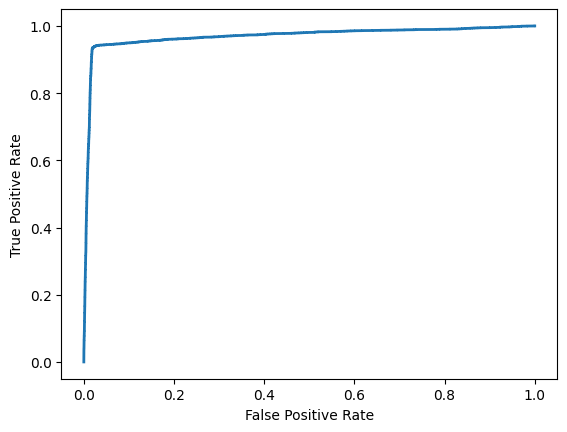

Model training and evaluation completed.


In [ ]:

prd_scores = cross_val_predict(rf_clf, X_processed ,y_processed, cv=20, method='predict_proba')
print(prd_scores)
fpr, tpr, thresholds = roc_curve(y_processed, prd_scores[:, 1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label, linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
plot_roc_curve(fpr, tpr, label='ROC Curve')
print("Model training and evaluation completed.")

In [118]:
rf_clf.fit(X_processed, y_processed)

test_data = pd.read_csv('test.csv')

test_data['Socializing_effect'] = test_data['Social_event_attendance'] + test_data['Going_outside'] 
test_data['probability_of_having_friends'] = test_data['Socializing_effect'] / (test_data['Socializing_effect'].max() + 1e-5)
test_data['prob_of_going_outside'] = test_data['Going_outside'] / (test_data['Going_outside'].max() + 1e-5)
test_data['online_presence'] = test_data['Post_frequency'] * test_data['Friends_circle_size']

test_data_processed = pre_processor.transform(test_data)
rf_predictions = rf_clf.predict(test_data_processed)
sub_data = pd.DataFrame({'id': test_data['id'], 'Personality': rf_predictions})
sub_data['Personality'] = le.inverse_transform(sub_data['Personality'])
sub_data.to_csv('submission.csv', index=False)
print("Submission file created.")

Submission file created.
